# Setup

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append("/workspace/circuit-finder")

## Load Models

In [6]:
from circuit_finder.pretrained import load_model
from circuit_finder.pretrained import load_attn_saes, load_hooked_mlp_transcoders
from circuit_finder.patching.indirect_leap import preprocess_attn_saes

model = load_model()
attn_sae_dict = load_attn_saes()
attn_sae_dict = preprocess_attn_saes(attn_sae_dict, model)
hooked_mlp_transcoder_dict = load_hooked_mlp_transcoders()

attn_saes = list(attn_sae_dict.values())
transcoders = list(hooked_mlp_transcoder_dict.values())

/workspace/circuit-finder/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

# Load Dataset


In [18]:
import pickle
from circuit_finder.constants import ProjectDir
from circuit_finder.paper.run_leap_experiment_batched import LeapExperimentResult


def load_result(
    dataset_name: str, threshold: float, sweep_name: str
) -> LeapExperimentResult:
    save_dir = (
        ProjectDir
        / "results"
        / sweep_name
        / f"dataset={dataset_name}_threshold={threshold}"
    )

    with open(save_dir / "result.pkl", "rb") as file:
        result = pickle.load(file)

    return result

In [ ]:
import pathlib
import pandas as pd
from circuit_finder.experiments.run_dataset_sweep import ALL_DATASETS
from circuit_finder.paper.run_leap_experiment_batched import THRESHOLDS

SWEEP_NAMES = ["c4_keep_error", "c4_ablate_error", "D_keep_error", "D_ablate_error"]


rows = []
for sweep_name in SWEEP_NAMES:
    for dataset_path in ALL_DATASETS:
        dataset_name = pathlib.Path(dataset_path).stem
        for threshold in THRESHOLDS:
            result = load_result(dataset_name, threshold, sweep_name)
            num_nodes = len(result.graph.get_src_nodes()) + len(
                result.error_graph.get_src_nodes()
            )
            rows.append(
                {
                    "sweep_name": sweep_name,
                    "dataset": dataset_name,
                    "threshold": threshold,
                    "num_nodes": num_nodes,
                    "clean_metric": result.clean_metric,
                    "ablate_metric": result.ablate_metric,
                    "corrupt_metric": result.corrupt_metric,
                }
            )

df = pd.DataFrame(rows)
df.head()

# Faithfulness Curves

For each sweep and dataset, we want to plot faithfulness over many different settings. 

<Axes: xlabel='threshold', ylabel='ablate_metric'>

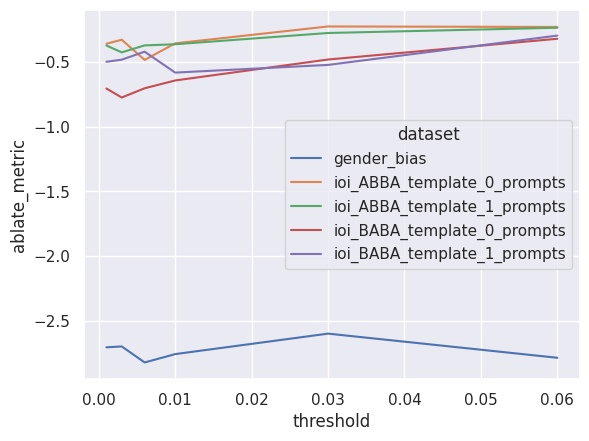

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

# Single setting
plot_df = df[(df.sweep_name == "c4_keep_error")]
sns.lineplot(data=df, x="threshold", y="ablate_metric", hue="dataset")

# Noising & Denoising Curves

In [ ]:
# Get the clean and corrupt cache
from circuit_finder.patching.ablate import (
    splice_model_with_saes_and_transcoders,
    filter_sae_acts_and_errors,
    get_ablation_result,
)

with splice_model_with_saes_and_transcoders(
    model, transcoders, attn_saes
) as spliced_model:
    _, clean_cache = model.run_with_cache(
        clean_tokens, names_filter=filter_sae_acts_and_errors
    )
    _, corrupt_cache = model.run_with_cache(
        corrupt_tokens, names_filter=filter_sae_acts_and_errors
    )

noising_result = get_ablation_result(
    model,
    transcoders,
    attn_saes,
    clean_tokens = clean_tokens,
    corrupt_tokens = corrupt_tokens,
    clean_cache = clean_cache,
    corrupt_cache = corrupt_cache,
    nodes = all_nodes,
    metric_fn = metric_fn,
    setting="noising",
)

denoising_result = get_ablation_result(
    model,
    transcoders,
    attn_saes,
    clean_tokens = clean_tokens,
    corrupt_tokens = corrupt_tokens,
    clean_cache = clean_cache,
    corrupt_cache = corrupt_cache,
    nodes = all_nodes,
    metric_fn = metric_fn,
    setting="denoising",
)